In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import datetime

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
## Packages for ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [4]:
%matplotlib inline
# width of figure =18, height of figure = 6
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6

In [5]:
df = pd.read_csv(r'C:\Users\doroudi.r\Documents\Kaggle\DemandForecasting\train.csv')

In [6]:
df.head(2)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11


In [7]:
df.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
date     913000 non-null object
store    913000 non-null int64
item     913000 non-null int64
sales    913000 non-null int64
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [9]:
df['store'].nunique()

10

In [10]:
df['item'].nunique()

50

In [11]:
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

### For the purpose of trying ARIMA concepts just keep 1 item and aggregate over stores

In [12]:
small_df = df[df['item']==1]
small_df = small_df.groupby(small_df.index).sum()
small_df = pd.DataFrame(small_df['sales'])

In [13]:
small_df.head(2)

,sales
date,
2013-01-01,133
2013-01-02,99


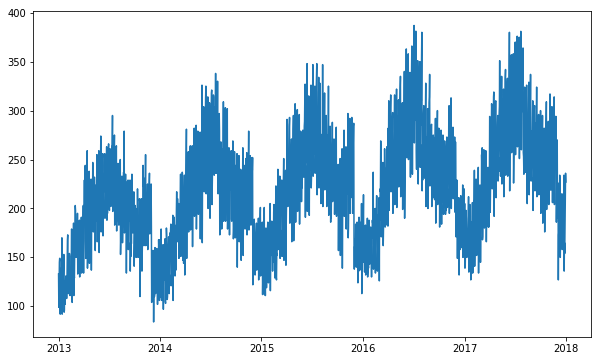

In [14]:
plt.figure(figsize = (10, 6))
plt.plot(small_df);

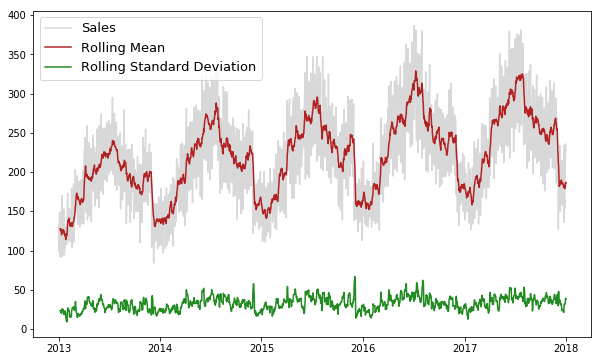

In [15]:
x =small_df.index
y_1 = small_df
y_2 = y_1.rolling(7).mean()
y_3 = y_1.rolling(7).std()
plt.plot(x, y_1, color = 'gray', alpha = 0.3, label = 'Sales')
plt.plot(x, y_2, color = 'firebrick', label = 'Rolling Mean')
plt.plot(x, y_3, color = 'forestgreen', label = 'Rolling Standard Deviation')
plt.legend(fontsize = 13);

In [16]:
# one lag differencing
diff_df = small_df - small_df.shift(1)

In [17]:
diff_df.head(2)

,sales
date,
2013-01-01,NaN
2013-01-02,-34.0


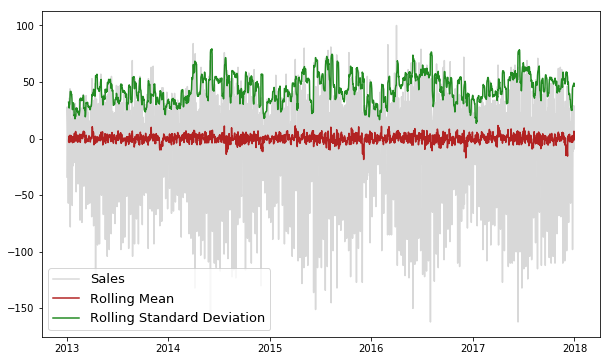

In [18]:
x =diff_df.index
y_1 = diff_df
y_2 = y_1.rolling(7).mean()
y_3 = y_1.rolling(7).std()
plt.plot(x, y_1, color = 'gray', alpha = 0.3, label = 'Sales')
plt.plot(x, y_2, color = 'firebrick', label = 'Rolling Mean')
plt.plot(x, y_3, color = 'forestgreen', label = 'Rolling Standard Deviation')
plt.legend(fontsize = 13);

In [19]:
# Dickey Fuller Test
result = adfuller(diff_df['sales'].iloc[1:])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('number of laggs used: %f' % result[2])
print('number of observations: %f' % result[3])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -9.450355
p-value: 0.000000
number of laggs used: 23.000000
number of observations: 1801.000000
Critical Values:
	5%: -2.863
	10%: -2.568
	1%: -3.434


Absolute value of test statistic is greater than the critical value, we can declare statistical significance and reject the null hypothesis. So **integrated time series is stationary** so we choose d in ARIMA(p,d,q) to be 1

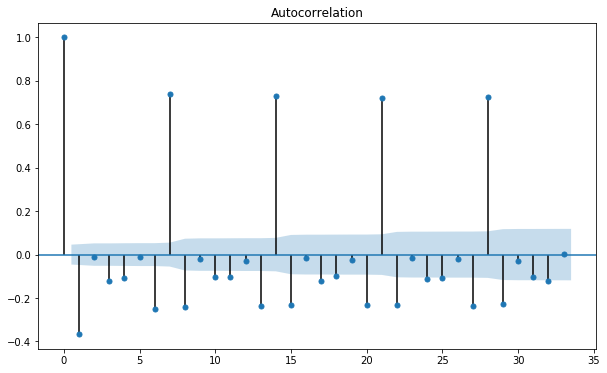

In [20]:
acf_plot = plot_acf(diff_df['sales'].iloc[1:])

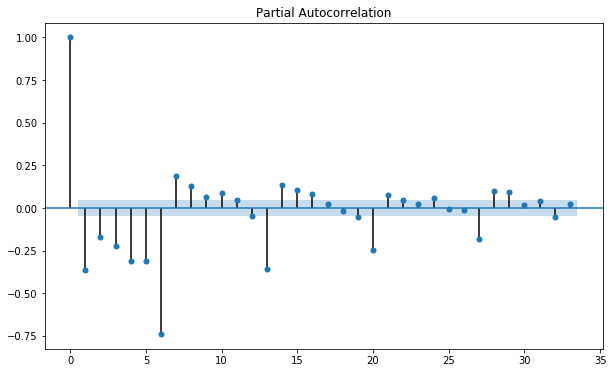

In [21]:
pacf_plot = plot_pacf(diff_df['sales'].iloc[1:])

ACF that cuts off sharply after a few lags and PACF that dies out more gradually -> **MA signature** -> q = 1
<br> you see ACF that cuts off sharply after a few lags and PACF that dies out more gradually at lags of 7 too so season = 7 and Q = 1

In [22]:
small_df.tail()

,sales
date,
2017-12-27,154
2017-12-28,178
2017-12-29,207
2017-12-30,236
2017-12-31,227


In [23]:
# separate last 3 months as test, since we want to be able to forecast for next 3 months
end_date = pd.to_datetime(datetime.date(year = 2017, month=10, day = 1))
df_train = small_df[small_df.index<end_date]
df_test = small_df[small_df.index>= end_date]

In [24]:
order_param = (0, 1, 1)
seas_order_param = (0, 1, 1, 7)
X = df_train['sales']
model = SARIMAX(X, order = order_param, seasonal_order= seas_order_param, initialization='approximate_diffuse').fit(disp=-1)
print(model.summary())

                                 Statespace Model Results                                
Dep. Variable:                             sales   No. Observations:                 1734
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 7)   Log Likelihood               -7502.518
Date:                           Tue, 10 Sep 2019   AIC                          15011.035
Time:                                   13:33:59   BIC                          15027.396
Sample:                               01-01-2013   HQIC                         15017.088
                                    - 09-30-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7261      0.014    -51.341      0.000      -0.754      -0.698
ma.S.L7       -0.9144      0.010    -88.046

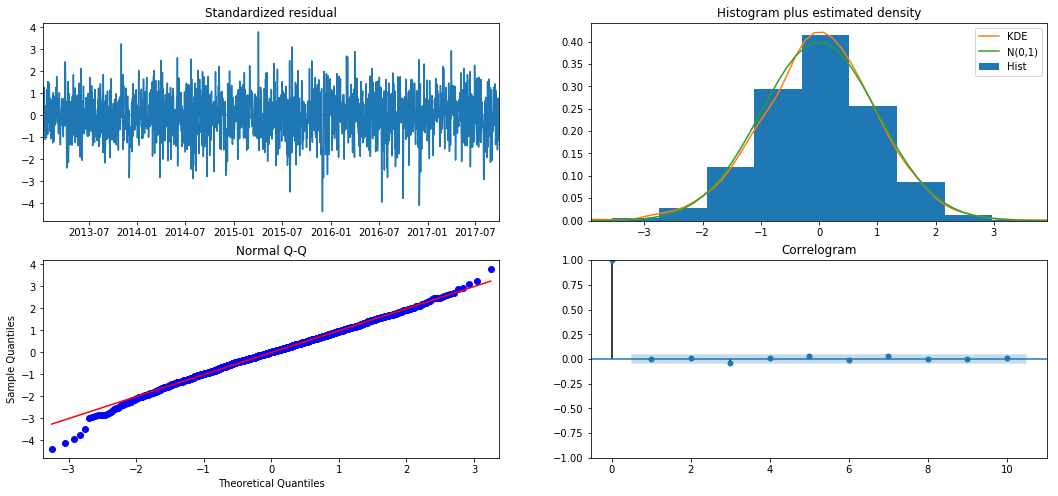

In [25]:
rcParams['figure.figsize'] = 18, 8
diagnostic_plot = model.plot_diagnostics()

### MSE of train

In [26]:
predicted = model.get_prediction().predicted_mean
actual = df_train.values
print('Mean Squared Error for Train Set is:', mean_squared_error(actual, predicted))

Mean Squared Error for Train Set is: 361.45019348314196


### Forecast for 3 months test data, MSE of test and plotting

In [27]:
forecasted = model.get_forecast(steps = len(df_test)).predicted_mean
actual = df_test.values
print('Mean Squared Error for Test Set is:', mean_squared_error(actual, forecasted))

Mean Squared Error for Test Set is: 884.4686244974546


In [28]:
# Confidence interval with default alpha = .05 
future_conf_int = model.get_forecast(steps = len(df_test)).conf_int()

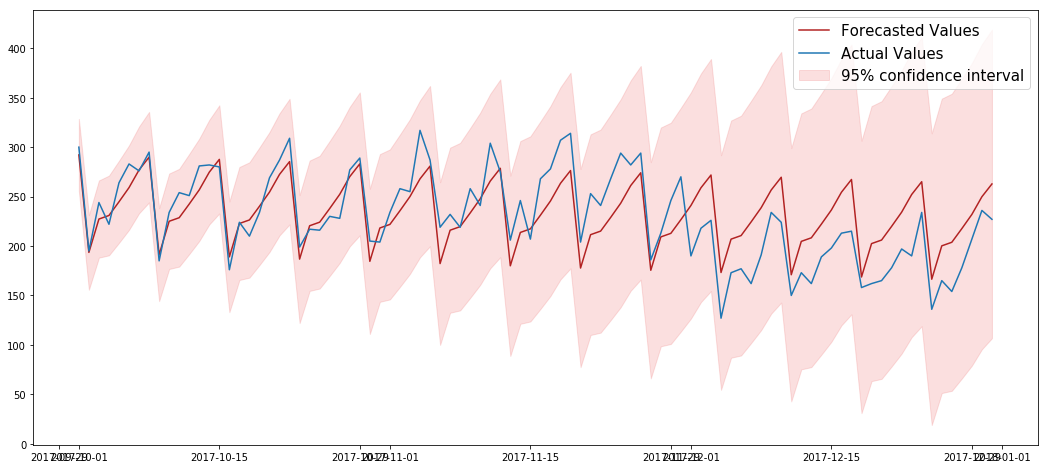

In [29]:
plt.plot(df_test.index, forecasted, color= 'firebrick', label = 'Forecasted Values')
plt.fill_between(df_test.index,
                   future_conf_int[:]['lower sales'],
                   future_conf_int[:]['upper sales'],
                   color='lightcoral', alpha=0.25, label = '95% confidence interval')
plt.plot(df_test.index, actual, label = 'Actual Values')
plt.legend(fontsize = 15);